In [1]:
import os
import math
import requests
import hashlib
import zipfile
import tarfile
import collections
def download(name, cache_dir=os.path.join('C:/Users/hasee/Desktop/cvtf', 'data')): #@save
    """下载⼀个DATA_HUB中的⽂件，返回本地⽂件名。"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok = True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname # Hit cache
    print(f'正在从{url}下载{fname}...') 
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [2]:
from torch.utils import data
#@save
def load_array(data_arrays, batch_size, is_train = True): 
    """构造一个 Pytorch 数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(
        dataset, batch_size, shuffle = is_train)

In [3]:
#@save
DATA_HUB = dict()  #@save
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/' #@save
def tokenize(lines, token='word'): #@save
    """将⽂本⾏拆分为单词或字符标记。"""
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('错误：未知令牌类型：' + token)
class Vocab:
    """文本词表"""
    def __init__(self, tokens = None, min_freq = 0, 
                 reserved_tokens = None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # 按出现频率排序
        counter = count_corpus(tokens)
        self.token_freqs = sorted(
            counter.items(), key = lambda x:x[1], reverse = True)
        # 未知标记的索引为零
        self.unk, uniq_tokens = 0, ['<unk>'] + reserved_tokens
        uniq_tokens += [
            token for token, freq in self.token_freqs 
            if freq >= min_freq and token not in uniq_tokens]
        self.idx_to_token, self.token_to_idx = [], dict()
        for token in uniq_tokens:
            self.idx_to_token.append(token)
            self.token_to_idx[token] = len(self.idx_to_token) - 1
    def __len__(self):
        return len(self.idx_to_token)
    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]
    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]
# 建立一个词汇表，将拆分的标记映射到数字索引
def count_corpus(tokens):  #@save
    """统计标记的频率"""
    # 这里 tokens 是 1D 或者 2D 列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # 将标记列表展平成使用标记填充的一个列表
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)
def download_extract(name, folder = None):
    """下载并解压了 zip/tar 文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有 zip/tar 文件可以压缩。'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir
def download_all():  #@save
    """下载 DATA_HUB 中的所有文件"""
    for name in DATA_HUB:
        download(name)
DATA_HUB['fra-eng'] = (DATA_URL + 'fra-eng.zip', 
                       '94646ad1522d915e7b0f9296181140edcf86a4f5')
def read_data_nmt():
    """载入 英语-法语 数据及"""
    data_dir = download_extract('fra-eng')
    with open(os.path.join(data_dir, 'fra.txt'), 'r', encoding="utf-8") as f:
        return f.read()
def preprocess_nmt(text):
    """预处理 英语-法语 数据集"""
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' '
    """使用空格代替不间断空格"""
    """使用小写代替大写"""
    text = text.replace(
        '\u202f', ' ').replace('\xa0', ' ').lower()
    """ \xa0: 表示的是空格字符 """
    """在单词和标点符号之间插入空格"""
    out = [
        ' ' + char if i > 0 and no_space(char, text[i - 1]) 
        else char for i, char in enumerate(text)]
    return ''.join(out)
def tokenize_nmt(text, num_examples = None):
    """标记化 英语-法语 数据集"""
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target
def truncate_pad(line, num_steps, padding_token):
    """截断或者填充文本"""
    if len(line) > num_steps:
        return line[:num_sreps]  # 截断
    return line + [padding_token] * (num_steps - len(line))  
def build_array_nmt(lines, vocab, num_steps):
    """将机器翻译的文本序列转换成小批量"""
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = torch.tensor(
        [truncate_pad(l, num_steps, vocab['<pad>']) 
         for l in lines])
    valid_len = (
        array != vocab['<pad>']).type(torch.int32).sum(1)
    return array, valid_len
def load_data_nmt(
    batch_size, num_steps, num_examples = 600):
    """返回数据集的迭代器和词汇表"""
    text = preprocess_nmt(d2l.read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = Vocab(
        source, min_freq = 2, reserved_tokens = [
            '<pad>', '<bos>', '<eos>'])
    tgt_vocab = Vocab(
        target, min_freq = 2, reserved_tokens = [
            '<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array_nmt(
        source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(
        target, src_vocab, num_steps)
    data_arrays = (
        src_array, src_valid_len, 
        tgt_array, tgt_valid_len)
    data_iter = d2l.load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab

In [4]:
#@save
def load_data_nmt(
    batch_size, num_steps, num_examples = 600):
    """返回数据集的迭代器和词汇表"""
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = Vocab(
        source, min_freq = 2, reserved_tokens = [
            '<pad>', '<bos>', '<eos>'])
    tgt_vocab = Vocab(
        target, min_freq = 2, reserved_tokens = [
            '<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array_nmt(
        source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(
        target, src_vocab, num_steps)
    data_arrays = (
        src_array, src_valid_len, 
        tgt_array, tgt_valid_len)
    data_iter = load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab

In [5]:
# 10.1 注意⼒提⽰
import torch
from d2l import torch as d2l

In [6]:
# 注意力的可视化 
#@save
def show_heatmaps(
    matrices, xlabel, ylabel, title = None, 
    figsize = (5.5, 5.5), cmap = 'Reds' ):
    d2l.use_svg_display
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]
    fig, axes = d2l.plt.subplots(
        num_rows, num_cols, figsize = figsize, 
        sharex = True, sharey = True, squeeze = False)
    for i, (row_axes, row_matrices) in enumerate(
        zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(
            zip(row_axes, row_matrices)):
            pcm = ax.imshow(
                matrix.detach().numpy(), cmap = cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if title:
                ax.set_title(title[j])
    fig.colorbar(pcm, ax = axes, shrink = 0.6)

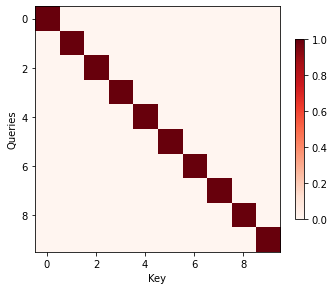

In [7]:
attention_weights = torch.eye(10).reshape((1, 1, 10, 10))
show_heatmaps(
    attention_weights, 
    xlabel = 'Key', ylabel = 'Queries')

In [9]:
# 2注意⼒汇聚：Nadaraya-Watson 核回归
import torch 
from torch import nn
from d2l import torch as d2l

In [10]:
# 生成数据集
n_train = 50
x_train, _ = torch.sort(torch.rand(n_train) * 5)  # 训练样本的输入
x_train.size()

torch.Size([50])

In [6]:
def f(x):
    return 2 * torch.sin(x) + x ** 0.8

In [7]:
y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train, ))  # 训练样本的输出
y_train.size()

torch.Size([50])

In [8]:
x_test = torch.arange(0, 5, 0.1)  # 测试样本
x_test.shape

torch.Size([50])

In [9]:
y_truth = f(x_test)
y_truth.size()

torch.Size([50])

In [10]:
n_test = len(x_test)
n_test

50

In [11]:
#@save
def plot_kernel_reg(y_hat):
    d2l.plot(
        x_test, [y_truth, y_hat], 'x', 'y', 
        legend = ['truth', 'pred'], 
        xlim = [0, 5], ylim = [-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha = 0.5)

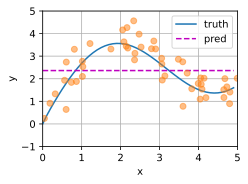

In [12]:
# 平均汇聚
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

In [13]:
y_hat

tensor([2.3617, 2.3617, 2.3617, 2.3617, 2.3617, 2.3617, 2.3617, 2.3617, 2.3617,
        2.3617, 2.3617, 2.3617, 2.3617, 2.3617, 2.3617, 2.3617, 2.3617, 2.3617,
        2.3617, 2.3617, 2.3617, 2.3617, 2.3617, 2.3617, 2.3617, 2.3617, 2.3617,
        2.3617, 2.3617, 2.3617, 2.3617, 2.3617, 2.3617, 2.3617, 2.3617, 2.3617,
        2.3617, 2.3617, 2.3617, 2.3617, 2.3617, 2.3617, 2.3617, 2.3617, 2.3617,
        2.3617, 2.3617, 2.3617, 2.3617, 2.3617])

In [14]:
x_test

tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000, 1.0000, 1.1000, 1.2000, 1.3000, 1.4000, 1.5000, 1.6000, 1.7000,
        1.8000, 1.9000, 2.0000, 2.1000, 2.2000, 2.3000, 2.4000, 2.5000, 2.6000,
        2.7000, 2.8000, 2.9000, 3.0000, 3.1000, 3.2000, 3.3000, 3.4000, 3.5000,
        3.6000, 3.7000, 3.8000, 3.9000, 4.0000, 4.1000, 4.2000, 4.3000, 4.4000,
        4.5000, 4.6000, 4.7000, 4.8000, 4.9000])

In [15]:
x_repeat = x_test.repeat_interleave(n_train)
x_repeat, x_repeat.shape

(tensor([0.0000, 0.0000, 0.0000,  ..., 4.9000, 4.9000, 4.9000]),
 torch.Size([2500]))

In [16]:
# 非参数注意力汇聚
x_repeat = x_test.repeat_interleave(
    n_train).reshape((-1, n_train))
x_repeat, x_repeat.shape

(tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
         [0.2000, 0.2000, 0.2000,  ..., 0.2000, 0.2000, 0.2000],
         ...,
         [4.7000, 4.7000, 4.7000,  ..., 4.7000, 4.7000, 4.7000],
         [4.8000, 4.8000, 4.8000,  ..., 4.8000, 4.8000, 4.8000],
         [4.9000, 4.9000, 4.9000,  ..., 4.9000, 4.9000, 4.9000]]),
 torch.Size([50, 50]))

In [17]:
attention_weights = nn.functional.softmax(
    -(x_repeat - x_train) ** 2 / 2, dim = 1)
attention_weights, attention_weights.shape

(tensor([[9.0935e-02, 8.9437e-02, 8.6409e-02,  ..., 9.1599e-07, 8.7787e-07,
          3.5187e-07],
         [8.4318e-02, 8.4120e-02, 8.2377e-02,  ..., 1.3660e-06, 1.3104e-06,
          5.3510e-07],
         [7.7894e-02, 7.8828e-02, 7.8243e-02,  ..., 2.0297e-06, 1.9487e-06,
          8.1076e-07],
         ...,
         [1.1091e-06, 2.1327e-06, 3.8848e-06,  ..., 5.5982e-02, 5.5931e-02,
          5.3889e-02],
         [7.3622e-07, 1.4360e-06, 2.6513e-06,  ..., 5.9767e-02, 5.9767e-02,
          5.8668e-02],
         [4.8675e-07, 9.6304e-07, 1.8022e-06,  ..., 6.3554e-02, 6.3609e-02,
          6.3617e-02]]),
 torch.Size([50, 50]))

In [18]:
y_hat = torch.matmul(attention_weights, y_train)
y_hat, y_hat.shape

(tensor([2.0026, 2.0518, 2.1031, 2.1564, 2.2117, 2.2689, 2.3279, 2.3882, 2.4496,
         2.5115, 2.5733, 2.6341, 2.6932, 2.7495, 2.8022, 2.8501, 2.8924, 2.9282,
         2.9567, 2.9773, 2.9898, 2.9937, 2.9892, 2.9763, 2.9553, 2.9267, 2.8912,
         2.8492, 2.8017, 2.7494, 2.6932, 2.6340, 2.5725, 2.5098, 2.4466, 2.3836,
         2.3215, 2.2610, 2.2026, 2.1467, 2.0936, 2.0436, 1.9967, 1.9532, 1.9130,
         1.8760, 1.8422, 1.8114, 1.7834, 1.7582]),
 torch.Size([50]))

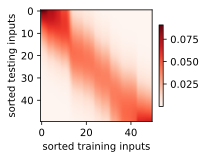

In [19]:
d2l.show_heatmaps(
    attention_weights.unsqueeze(0).unsqueeze(0), 
    xlabel = 'sorted training inputs', 
    ylabel = 'sorted testing inputs')

In [20]:
# 带参数注意力汇聚
# 批量矩阵乘法
x = torch.ones((2, 1, 4))
y = torch.ones((2, 4, 6))
torch.bmm(x, y).shape

torch.Size([2, 1, 6])

In [21]:
weights = torch.ones((2, 10)) * 0.1
values = torch.arange(20.0).reshape((2, 10))
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1)), \
torch.bmm(
    weights.unsqueeze(1), values.unsqueeze(-1)).size()

(tensor([[[ 4.5000]],
 
         [[14.5000]]]),
 torch.Size([2, 1, 1]))

In [22]:
weights, weights.unsqueeze(1), \
weights.shape, weights.unsqueeze(1).shape  # 增加维度

(tensor([[0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
          0.1000],
         [0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
          0.1000]]),
 tensor([[[0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
           0.1000, 0.1000]],
 
         [[0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
           0.1000, 0.1000]]]),
 torch.Size([2, 10]),
 torch.Size([2, 1, 10]))

In [23]:
values, values.unsqueeze(-1), \
values.shape, values.unsqueeze(-1).shape  # 增加维度

(tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.],
         [10., 11., 12., 13., 14., 15., 16., 17., 18., 19.]]),
 tensor([[[ 0.],
          [ 1.],
          [ 2.],
          [ 3.],
          [ 4.],
          [ 5.],
          [ 6.],
          [ 7.],
          [ 8.],
          [ 9.]],
 
         [[10.],
          [11.],
          [12.],
          [13.],
          [14.],
          [15.],
          [16.],
          [17.],
          [18.],
          [19.]]]),
 torch.Size([2, 10]),
 torch.Size([2, 10, 1]))

In [24]:
# 定义模型 
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(
            torch.rand((1, ), requires_grad = True))
    def forward(self, queries, keys, valuess):
        queries = queries.repeat_interleave(
            keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = nn.functional.\
            softmax(
                -((queries - keys) * self.w) ** 2 / 2, 
                dim = 1)
        return torch.bmm(
            self.attention_weights.unsqueeze(1), 
            values.unsqueeze(-1)).reshape(-1)

In [25]:
x_train

tensor([0.0451, 0.1878, 0.3227, 0.5626, 0.6018, 0.6062, 0.7370, 0.8134, 0.8654,
        1.0186, 1.0200, 1.0314, 1.2149, 1.7513, 2.0523, 2.0863, 2.1443, 2.1641,
        2.1848, 2.3365, 2.3581, 2.3679, 2.4746, 2.5257, 2.7930, 2.8531, 2.8990,
        3.0527, 3.0597, 3.0694, 3.1368, 3.4829, 3.5950, 3.6023, 3.7088, 3.8267,
        3.9926, 4.0420, 4.0537, 4.0693, 4.0892, 4.1419, 4.1903, 4.6484, 4.6521,
        4.6768, 4.7275, 4.7972, 4.8061, 4.9927])

In [26]:
# 训练模型
x_title = x_train.repeat((n_train, 1))  
# 每⼀⾏都包含着相同的训练输⼊
x_train.size(), n_train, x_title.size(), x_title

(torch.Size([50]),
 50,
 torch.Size([50, 50]),
 tensor([[0.0451, 0.1878, 0.3227,  ..., 4.7972, 4.8061, 4.9927],
         [0.0451, 0.1878, 0.3227,  ..., 4.7972, 4.8061, 4.9927],
         [0.0451, 0.1878, 0.3227,  ..., 4.7972, 4.8061, 4.9927],
         ...,
         [0.0451, 0.1878, 0.3227,  ..., 4.7972, 4.8061, 4.9927],
         [0.0451, 0.1878, 0.3227,  ..., 4.7972, 4.8061, 4.9927],
         [0.0451, 0.1878, 0.3227,  ..., 4.7972, 4.8061, 4.9927]]))

In [27]:
y_title = y_train.repeat((n_train, 1))
y_title
# 每⼀⾏都包含着相同的训练输出

tensor([[0.2445, 0.9157, 1.3311,  ..., 0.8975, 1.4098, 2.0197],
        [0.2445, 0.9157, 1.3311,  ..., 0.8975, 1.4098, 2.0197],
        [0.2445, 0.9157, 1.3311,  ..., 0.8975, 1.4098, 2.0197],
        ...,
        [0.2445, 0.9157, 1.3311,  ..., 0.8975, 1.4098, 2.0197],
        [0.2445, 0.9157, 1.3311,  ..., 0.8975, 1.4098, 2.0197],
        [0.2445, 0.9157, 1.3311,  ..., 0.8975, 1.4098, 2.0197]])

In [28]:
a =  (1 - torch.eye(n_train))
a

tensor([[0., 1., 1.,  ..., 1., 1., 1.],
        [1., 0., 1.,  ..., 1., 1., 1.],
        [1., 1., 0.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 0., 1., 1.],
        [1., 1., 1.,  ..., 1., 0., 1.],
        [1., 1., 1.,  ..., 1., 1., 0.]])

In [29]:
a.type(torch.bool)

tensor([[False,  True,  True,  ...,  True,  True,  True],
        [ True, False,  True,  ...,  True,  True,  True],
        [ True,  True, False,  ...,  True,  True,  True],
        ...,
        [ True,  True,  True,  ..., False,  True,  True],
        [ True,  True,  True,  ...,  True, False,  True],
        [ True,  True,  True,  ...,  True,  True, False]])

In [30]:
x_title

tensor([[0.0451, 0.1878, 0.3227,  ..., 4.7972, 4.8061, 4.9927],
        [0.0451, 0.1878, 0.3227,  ..., 4.7972, 4.8061, 4.9927],
        [0.0451, 0.1878, 0.3227,  ..., 4.7972, 4.8061, 4.9927],
        ...,
        [0.0451, 0.1878, 0.3227,  ..., 4.7972, 4.8061, 4.9927],
        [0.0451, 0.1878, 0.3227,  ..., 4.7972, 4.8061, 4.9927],
        [0.0451, 0.1878, 0.3227,  ..., 4.7972, 4.8061, 4.9927]])

In [31]:
x_title[(1 - torch.eye(n_train)).type(torch.bool)], \
x_title[(1 - torch.eye(n_train)).type(torch.bool)].size()

(tensor([0.1878, 0.3227, 0.5626,  ..., 4.7275, 4.7972, 4.8061]),
 torch.Size([2450]))

In [32]:
keys = x_title[
    (1 - torch.eye(n_train)).type(torch.bool)].reshape(
    (n_train, -1))
keys, keys.shape

(tensor([[0.1878, 0.3227, 0.5626,  ..., 4.7972, 4.8061, 4.9927],
         [0.0451, 0.3227, 0.5626,  ..., 4.7972, 4.8061, 4.9927],
         [0.0451, 0.1878, 0.5626,  ..., 4.7972, 4.8061, 4.9927],
         ...,
         [0.0451, 0.1878, 0.3227,  ..., 4.7275, 4.8061, 4.9927],
         [0.0451, 0.1878, 0.3227,  ..., 4.7275, 4.7972, 4.9927],
         [0.0451, 0.1878, 0.3227,  ..., 4.7275, 4.7972, 4.8061]]),
 torch.Size([50, 49]))

In [33]:
values = y_title[
    (1 - torch.eye(n_train)).type(torch.bool)].reshape(
    (n_train, -1))
values, values.shape

(tensor([[0.9157, 1.3311, 1.9330,  ..., 0.8975, 1.4098, 2.0197],
         [0.2445, 1.3311, 1.9330,  ..., 0.8975, 1.4098, 2.0197],
         [0.2445, 0.9157, 1.9330,  ..., 0.8975, 1.4098, 2.0197],
         ...,
         [0.2445, 0.9157, 1.3311,  ..., 1.6421, 1.4098, 2.0197],
         [0.2445, 0.9157, 1.3311,  ..., 1.6421, 0.8975, 2.0197],
         [0.2445, 0.9157, 1.3311,  ..., 1.6421, 0.8975, 1.4098]]),
 torch.Size([50, 49]))

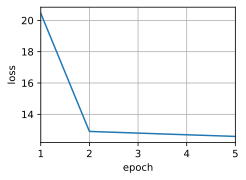

In [34]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction = 'none')
trainer = torch.optim.SGD(net.parameters(), lr = 0.5)
animator = d2l.Animator(
    xlabel = 'epoch', ylabel = 'loss', xlim = [1, 5] )
for epoch in range(5):
    trainer.zero_grad()
    # 注意 L2 损失是 = 1 / 2 * MSELoss
    l = loss(net(x_train, keys, values), y_train) / 2
    l.sum().backward()
    trainer.step()
    print(f"epoch:{epoch + 1}, \
          loss:{float(l.sum()):.6f}")
    animator.add(epoch + 1, float(l.sum()))

In [35]:
keys = x_train.repeat((n_test, 1))
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()

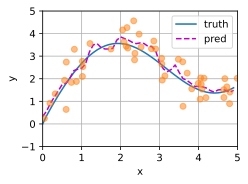

In [36]:
plot_kernel_reg(y_hat)

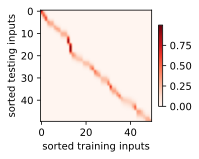

In [37]:
d2l.show_heatmaps(
    net.attention_weights.unsqueeze(0).unsqueeze(0), 
    xlabel = 'sorted training inputs', 
    ylabel = 'sorted testing inputs')

In [38]:
# 3.注意力评分函数
import torch
from torch import nn
from d2l import torch as d2l

In [39]:
# 遮蔽 Softmax 操作
x = torch.rand(2, 2, 4)
x, x.size()

(tensor([[[0.9770, 0.0981, 0.9161, 0.0367],
          [0.1608, 0.8872, 0.3536, 0.5556]],
 
         [[0.3268, 0.5062, 0.0817, 0.8750],
          [0.1429, 0.7614, 0.7636, 0.1188]]]),
 torch.Size([2, 2, 4]))

In [40]:
valid_lens = torch.tensor([2, 3])
valid_lens, valid_lens.size()

(tensor([2, 3]), torch.Size([2]))

In [41]:
valid_lens is None

False

In [42]:
nn.functional.softmax(x, dim = -1)

tensor([[[0.3641, 0.1512, 0.3426, 0.1422],
         [0.1735, 0.3587, 0.2104, 0.2575]],

        [[0.2123, 0.2541, 0.1662, 0.3674],
         [0.1757, 0.3261, 0.3268, 0.1715]]])

In [43]:
shape = x.shape
shape, shape[1]

(torch.Size([2, 2, 4]), 2)

In [44]:
valid_lens.dim() == 1

True

In [45]:
x.dim()

3

In [46]:
valid_lens = torch.repeat_interleave(valid_lens, shape[1])
valid_lens

tensor([2, 2, 3, 3])

In [47]:
a = x.reshape(-1, shape[-1])
a, a.size()

(tensor([[0.9770, 0.0981, 0.9161, 0.0367],
         [0.1608, 0.8872, 0.3536, 0.5556],
         [0.3268, 0.5062, 0.0817, 0.8750],
         [0.1429, 0.7614, 0.7636, 0.1188]]),
 torch.Size([4, 4]))

In [48]:
b = d2l.sequence_mask(
    x.reshape(-1, shape[-1]), valid_lens, value = -1e6)
b

tensor([[ 9.7698e-01,  9.8123e-02, -1.0000e+06, -1.0000e+06],
        [ 1.6077e-01,  8.8716e-01, -1.0000e+06, -1.0000e+06],
        [ 3.2679e-01,  5.0621e-01,  8.1730e-02, -1.0000e+06],
        [ 1.4294e-01,  7.6143e-01,  7.6365e-01, -1.0000e+06]])

In [49]:
c = x.reshape(shape)
c

tensor([[[ 9.7698e-01,  9.8123e-02, -1.0000e+06, -1.0000e+06],
         [ 1.6077e-01,  8.8716e-01, -1.0000e+06, -1.0000e+06]],

        [[ 3.2679e-01,  5.0621e-01,  8.1730e-02, -1.0000e+06],
         [ 1.4294e-01,  7.6143e-01,  7.6365e-01, -1.0000e+06]]])

In [50]:
nn.functional.softmax(c, dim = -1)

tensor([[[0.7066, 0.2934, 0.0000, 0.0000],
         [0.3260, 0.6740, 0.0000, 0.0000]],

        [[0.3357, 0.4016, 0.2627, 0.0000],
         [0.2120, 0.3935, 0.3944, 0.0000]]])

In [51]:
valid_len = torch.tensor([[1, 3], [2, 4]])
d = valid_len.reshape(-1)
d

tensor([1, 3, 2, 4])

In [52]:
#@save
def masked_softmax(x, valid_lens):
    """通过在最后一个轴上遮蔽元素来执行 softmax 操作"""
    # x: 3D 张量， valid_lens: 1D 或者 2D 张量
    if valid_lens is None:
        return nn.functional.softmax(x, dim = -1)
    else:
        shape = x.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(
                valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        x = d2l.sequence_mask(
            x.reshape(-1, shape[-1]), valid_lens, value = -1e6)
        return nn.functional.softmax(x.reshape(shape), dim = -1)

In [53]:
x, valid_lens = torch.rand(2, 2, 4), torch.tensor([2, 3])

In [54]:
d2l.masked_softmax(x, valid_lens)

tensor([[[0.5326, 0.4674, 0.0000, 0.0000],
         [0.4530, 0.5470, 0.0000, 0.0000]],

        [[0.3628, 0.2591, 0.3780, 0.0000],
         [0.2404, 0.3347, 0.4249, 0.0000]]])

In [55]:
valid_lens = torch.tensor([[1, 3], [2, 4]])
masked_softmax(x, valid_lens)

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.4530, 0.5470, 0.0000, 0.0000]],

        [[0.5833, 0.4167, 0.0000, 0.0000],
         [0.2404, 0.3347, 0.4249, 0.0000]]])

In [56]:
a = torch.arange(40, dtype = torch.float32).reshape(1, 10, 4)
a

tensor([[[ 0.,  1.,  2.,  3.],
         [ 4.,  5.,  6.,  7.],
         [ 8.,  9., 10., 11.],
         [12., 13., 14., 15.],
         [16., 17., 18., 19.],
         [20., 21., 22., 23.],
         [24., 25., 26., 27.],
         [28., 29., 30., 31.],
         [32., 33., 34., 35.],
         [36., 37., 38., 39.]]])

In [57]:
b = a.repeat(2, 1, 1)
c = a.repeat(2, 1, 2)
b.size(), c.size()

(torch.Size([2, 10, 4]), torch.Size([2, 10, 8]))

In [58]:
key_size = 2
query_size = 20
num_hiddens = 8
dropout = 0.1

In [59]:
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))
queries, keys

(tensor([[[-1.3167, -0.3960,  0.5621,  1.1960,  0.4458, -0.1880, -0.9067,
            1.4616, -0.2671, -0.5776,  1.7087, -0.9453,  0.3479,  1.3084,
            0.3305, -1.6147, -0.6269, -1.3268,  0.6337,  0.9674]],
 
         [[ 0.2836, -0.9441,  0.5019,  0.8951, -0.5590,  0.7459, -0.4073,
            0.2722,  1.0424,  0.8260,  1.1783, -0.1017,  0.5838, -0.7403,
            0.9219,  0.5241, -0.3575,  2.1594,  0.6893,  1.4200]]]),
 tensor([[[1., 1.],
          [1., 1.],
          [1., 1.],
          [1., 1.],
          [1., 1.],
          [1., 1.],
          [1., 1.],
          [1., 1.],
          [1., 1.],
          [1., 1.]],
 
         [[1., 1.],
          [1., 1.],
          [1., 1.],
          [1., 1.],
          [1., 1.],
          [1., 1.],
          [1., 1.],
          [1., 1.],
          [1., 1.],
          [1., 1.]]]))

In [60]:
w_k = nn.Linear(key_size, num_hiddens, bias = False)
w_q = nn.Linear(query_size, num_hiddens, bias = False)
w_k, w_q

(Linear(in_features=2, out_features=8, bias=False),
 Linear(in_features=20, out_features=8, bias=False))

In [61]:
w_k_out = w_k(keys)
w_k_out.size()  # batch_size = 2

torch.Size([2, 10, 8])

In [62]:
w_q_out = w_q(queries)
w_q_out.size()

torch.Size([2, 1, 8])

In [63]:
q = w_k_out.unsqueeze(1)
q.size()  # batch_size, 查询的个数, 1, num_hiddens

torch.Size([2, 1, 10, 8])

In [64]:
w = w_q_out.unsqueeze(2)
w.size()  # batch_size, 1, 键值对的个数, num_hiddens

torch.Size([2, 1, 1, 8])

In [65]:
feature = q + w
feature.size()  # 运用了广播

torch.Size([2, 1, 10, 8])

In [66]:
w_v = nn.Linear(num_hiddens, 1, bias = False)
w_v

Linear(in_features=8, out_features=1, bias=False)

In [67]:
m = w_v(feature).shape
m

torch.Size([2, 1, 10, 1])

In [68]:
n = w_v(feature).squeeze(-1)
n.size()

torch.Size([2, 1, 10])

In [69]:
valid_lens = torch.tensor([2, 6])

In [70]:
attention_weight = masked_softmax(n, valid_lens)
attention_weight.size()

torch.Size([2, 1, 10])

In [71]:
attention_weight

tensor([[[0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000,
          0.0000, 0.0000]]], grad_fn=<SoftmaxBackward>)

In [72]:
dropout = nn.Dropout(0.1)
values = b
torch.bmm(dropout(attention_weight), values), \
torch.bmm(dropout(attention_weight), values).shape

(tensor([[[ 2.2222,  3.3333,  4.4444,  5.5556]],
 
         [[ 8.8889,  9.8148, 10.7407, 11.6667]]], grad_fn=<BmmBackward0>),
 torch.Size([2, 1, 4]))

In [73]:
# 加性注意力
#@save
class AdditiveAttention(nn.Module):
    """加性注意力"""
    def __init__(
        self, key_size, query_size, 
        num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.w_k = nn.Linear(
            key_size, num_hiddens, bias = False)
        self.w_q = nn.Linear(
            query_size, num_hiddens, bias = False)
        self.w_v = nn.Linear(num_hiddens, 1, bias = False)
        self.dropout = nn.Dropout(dropout)
    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.w_q(queries), self.w_k(keys)
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(
            scores, valid_lens)
        return torch.bmm(
            self.dropout(self.attention_weights), values)

In [74]:
values = torch.arange(
    40, dtype = torch.float32).reshape(1, 10, 4).repeat(2, 1, 1)
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))
valid_lens = torch.tensor([2, 6])

In [75]:
attention = AdditiveAttention(
    key_size = 2, query_size = 20, 
    num_hiddens = 8, dropout = 0.1)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

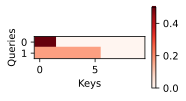

In [76]:
d2l.show_heatmaps(
    attention.attention_weights.reshape((1, 1, 2, 10)), 
    xlabel = 'Keys', ylabel = 'Queries')

In [77]:
queries = torch.normal(0, 1, (2, 1, 2))
keys = torch.rand((2, 10, 2))
valid_lens = torch.tensor([3, 8])

In [78]:
d = queries.shape[-1]
d

2

In [79]:
a = keys.transpose(1, 2)
a.size()

torch.Size([2, 2, 10])

In [80]:
# 缩放点积注意力
#@save
class DotProductAttention(nn.Module):
    """缩放点积注意力"""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
    def forward(self, queries, keys, values, valid_lens = None):
        d = queries.shape[-1]
        scores = torch.bmm(
            queries, keys.transpose(1, 2)) / torch.sqrt(
            torch.tensor([d]))
        self.attention_weights = masked_softmax(
            scores, valid_lens)
        return torch.bmm(
            self.dropout(self.attention_weights), values)

In [81]:
attention = DotProductAttention(dropout = 0.5)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 5.0057,  6.0057,  7.0057,  8.0057]],

        [[13.8191, 14.8191, 15.8191, 16.8191]]])

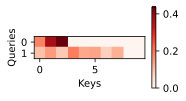

In [82]:
d2l.show_heatmaps(
    attention.attention_weights.reshape((1, 1, 2, 10)), 
    xlabel = 'Keys', ylabel = 'Queries')

In [83]:
# 4.Bahdanau 注意力
vocab_size = 10
embed_size = 8
num_hiddens = 16
num_layers = 2
dropout = 0

In [84]:
attention = AdditiveAttention(
    num_hiddens, num_hiddens, num_hiddens, dropout)
attention

AdditiveAttention(
  (w_k): Linear(in_features=16, out_features=16, bias=False)
  (w_q): Linear(in_features=16, out_features=16, bias=False)
  (w_v): Linear(in_features=16, out_features=1, bias=False)
  (dropout): Dropout(p=0, inplace=False)
)

In [85]:
embedding = nn.Embedding(vocab_size, embed_size)
embedding

Embedding(10, 8)

In [86]:
rnn = nn.GRU(
    embed_size + num_hiddens, 
    num_hiddens, num_layers, dropout = dropout)
rnn

GRU(24, 16, num_layers=2)

In [87]:
dense = nn.Linear(num_hiddens, vocab_size)
dense

Linear(in_features=16, out_features=10, bias=True)

In [88]:
X = torch.zeros((4, 7), dtype = torch.long)
X, X.shape  # batch_size, num_steps

(tensor([[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0]]),
 torch.Size([4, 7]))

In [89]:
a = embedding(X).permute(1, 0, 2)
a.size()

torch.Size([7, 4, 8])

In [90]:
for b in X:
    print(b)

tensor([0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0])


In [91]:
import torch
from torch import nn
from d2l import torch as d2l

In [92]:
# 定义注意力解码器
#@save
class Decoder(nn.Module):
    def __init_(self, **kwargs):
        super(Decoder, self).__init__(**kwargs)
    def init_state(self, enc_outputs, *args):
        raise NotImplementedError
    def forward(self, x, state):
        raise NotImplementedError
#@save
class AttentionDecoder(Decoder):
    """带有注意力机制的解码器接口"""
    def __init__(self, **kwargs):
        super(AttentionDecoder).__init__(**kwargs)
    @property
    def attention_weights(self):
        raise NotImplementedError

In [93]:
v = torch.randn(1, 2, 3)
v, v.size()

(tensor([[[ 0.3226,  1.9187, -2.2241],
          [-0.1370, -0.5766, -0.0792]]]),
 torch.Size([1, 2, 3]))

In [94]:
n = v.permute(1, 2, 0)
n.size()

torch.Size([2, 3, 1])

In [95]:
#@save
class Seq2SeqAttentionDecoder(nn.Module):
    def __init__(self, vocab_size, embed_size, 
        num_hiddens, num_layers, dropout = 0, **kwargs):
        super(Seq2SeqAttentionDecoder, 
              self).__init__(**kwargs)
        self.attention = d2l.AdditiveAttention(
            num_hiddens, num_hiddens, num_hiddens, 
            dropout)
        self.embedding = nn.Embedding(
            vocab_size, embed_size)
        self.rnn = nn.GRU(
            embed_size + num_hiddens, num_hiddens, 
            num_layers, dropout = dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)
    def init_state(
        self, enc_outputs, enc_valid_lens, *args):
        # enc_outputs: batch_size, num_steps, num_hiddens
        # hiddens_state:num_layers,batch_size, num_hiddens
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1, 0, 2), 
                hidden_state, enc_valid_lens)
    def forward(self, X, state):
        enc_outputs, hidden_state, enc_valid_lens = state
        # 输出 X 形状为: num_steps, batch_size, embed_size
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X:
            # queries: batch_size, 1, num_hiddens
            query = torch.unsqueeze(
                hidden_state[-1], dim = 1)
            # context: batch_size, 1, num_hiddens
            context = self.attention(
                query, enc_outputs, enc_outputs, 
                enc_valid_lens)
            x = torch.cat(
                (context, torch.unsqueeze(x, dim = 1)), 
                dim = -1)
            # x: 1, batch_size, embed_size + num_hiddens
            out, hidden_state = self.rnn(
                x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
            self._attention_weights.append(
                self.attention.attention_weights)
        # outputs: num_steps, batch_size, vocab_size
        outputs = self.dense(torch.cat(outputs, dim = 0))
        return (outputs.permute(1, 0, 2), 
                [enc_outputs, hidden_state, 
                 enc_valid_lens])
    
    @property
    def attention_weights(self):
        return self._attention_weights

In [96]:
encoder = d2l.Seq2SeqEncoder(
    vocab_size = 10, embed_size = 8, 
    num_hiddens = 16, num_layers = 2)
encoder.eval()

Seq2SeqEncoder(
  (embedding): Embedding(10, 8)
  (rnn): GRU(8, 16, num_layers=2)
)

In [97]:
decoder = Seq2SeqAttentionDecoder(
    vocab_size = 10, embed_size = 8, 
    num_hiddens = 16, num_layers = 2)
decoder.eval()

Seq2SeqAttentionDecoder(
  (attention): AdditiveAttention(
    (W_k): Linear(in_features=16, out_features=16, bias=False)
    (W_q): Linear(in_features=16, out_features=16, bias=False)
    (w_v): Linear(in_features=16, out_features=1, bias=False)
    (dropout): Dropout(p=0, inplace=False)
  )
  (embedding): Embedding(10, 8)
  (rnn): GRU(24, 16, num_layers=2)
  (dense): Linear(in_features=16, out_features=10, bias=True)
)

In [99]:
X = torch.zeros((4, 7), dtype = torch.long)  
# X: batch_size, num_steps
state = decoder.init_state(encoder(X), None)
outputs, state = decoder(X, state)
outputs.shape, len(state), state[0].shape, \
len(state[1]), state[1][0].shape

(torch.Size([4, 7, 10]), 3, torch.Size([4, 7, 16]), 2, torch.Size([4, 16]))

In [100]:
# 训练
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 250, d2l.try_gpu()

In [124]:
train_iter, src_vocab, tgt_vocab = load_data_nmt(
    batch_size, num_steps)

In [128]:
encoder = d2l.Seq2SeqEncoder(
    len(src_vocab), embed_size, 
    num_hiddens, num_layers, dropout)

In [129]:
decoder = Seq2SeqAttentionDecoder(
    len(tgt_vocab), embed_size, 
    num_hiddens, num_layers, dropout)

In [130]:
net = d2l.EncoderDecoder(encoder, decoder)

loss 0.008, 4897.0 tokens/sec on cuda:0


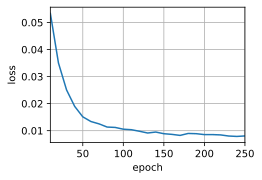

In [131]:
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [137]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weights_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, 
        num_steps, device, True)
    print(f"{eng}: {translation}, blue: {d2l.bleu(translation, fra, k = 2):.3f}")

go .: <unk> !, blue: 0.000
i lost .: <unk> <unk> ., blue: 0.000
he's calm .: <unk> <unk> <unk> ., blue: 0.000
i'm home .: <unk> <unk> <unk> <unk> ., blue: 0.000


In [139]:
attention_weights = torch.cat(
    [step[0][0][0] for step in 
     dec_attention_weights_seq], 0).reshape(
    (1, 1, -1, num_steps))

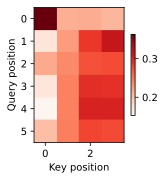

In [141]:
d2l.show_heatmaps(
    attention_weights[:, :, :, :len(engs[-1].split()) + 1].cpu(), 
    xlabel = 'Key position', ylabel = 'Query position')

In [12]:
# 5.多头注意力
valid_lens = torch.tensor([3, 2])
valid_lens

tensor([3, 2])

In [15]:
num_heads = 5
valid_len = torch.repeat_interleave(
    valid_lens, repeats = num_heads, dim = 0)
valid_len, valid_len.shape  

(tensor([3, 3, 3, 3, 3, 2, 2, 2, 2, 2]), torch.Size([10]))

In [16]:
import math
import torch
from torch import nn
from d2l import torch as d2l

In [18]:
#@save
def transpose_qkv(x, num_heads):
    x = x.reshape(x.shape[0], x.shape[1], num_heads, -1)
    x = x.permute(0, 2, 1, 3)
    return x.reshape(-1, x.shape[2], x.shape[3])

In [19]:
#@save
def transpose_output(x, num_heads):
    x = x.reshape(-1, num_heads, x.shape[1], x.shape[0])
    x = x.permute(0, 2, 1, 3)
    return x.reshape(x.shape[0], x.shape[1], -1)

In [20]:
# 实现
#@save
class MultiHeadAttention(nn.Module):
    def __init__(
        self, key_sizes, query_size, 
        value_size, num_hiddens, 
        num_heads, dropout, bias=False, **kwargs):
        super(MultiHeadAttention).__init__(**kwargs)
        self.num_heads = num_heads
        self.attention = d2l.DotProductAttention(dropout)
        self.w_q = nn.Linear(query_size, num_hiddens, bias = False)
        self.w_v = nn.Linear(value_size, num_hiddens, bias = False)
        self.w_k = nn.Linear(key_size, num_hiddens, bias = False)
        self.w_o = nn.Linear(num_hiddens, num_hiddens, bias = False)
    def forward(self, queries, keys, values, valid_lens):
        queries = transpose_qkv(self.w_q(queries), self.num_heads)
        keys = transpose_qkv(self.w_k(keys), self.num_heads)
        values = transpose_qkv(self.w_v(values), self.num_heads)
        if valid_lens is not None:
            valid_lens = torch.repeat_interleave(
                valid_lens, repeats = self.num_heads, dim = 0)
        output = self.attention(queries, keys, values, valid_lens)
        output_concat = transpose_output(output, self.num_heads)
        return self.w_o(output_concat)

In [21]:
num_hiddens, num_heads = 100, 5

In [23]:
attention = d2l.MultiHeadAttention(
    num_hiddens, num_hiddens, num_hiddens, 
    num_hiddens, num_heads, 0.5)
attention.eval()

MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)

In [25]:
batch_size, num_queries, num_kvpairs = 2, 4, 6
valid_lens = torch.tensor([3, 2])

In [26]:
x = torch.ones((batch_size, num_queries, num_hiddens))
y = torch.ones((batch_size, num_kvpairs, num_hiddens))
attention(x, y, y, valid_lens).shape

torch.Size([2, 4, 100])

In [3]:
# 6.自注意力和位置编码
import math
import torch
from d2l import torch as d2l
from torch import nn

In [4]:
# 自注意力
num_hiddens, num_heads = 100, 5
attention = d2l.MultiHeadAttention(
    num_hiddens, num_hiddens, num_hiddens, 
    num_hiddens, num_heads, 0.5)
attention.eval()

MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)

In [5]:
batch_size, num_queries, valid_lens = 2, 4, torch.tensor([3, 2])
x = torch.ones((batch_size, num_queries, num_hiddens))
attention(x, x, x, valid_lens).shape

torch.Size([2, 4, 100])

In [1]:
# 位置编码
# 绝对位置信息
encoding_dim = 32
num_steps = 60

In [9]:
x = torch.arange(1000, dtype = torch.float32)
x = x.reshape(-1, 1)
x.size()

torch.Size([1000, 1])

In [19]:
p = torch.randn((2, 6, 6))
p, p.size()

(tensor([[[ 1.5882, -0.5104, -1.2409, -0.4171, -0.7329,  0.4656],
          [-1.0824, -1.6960,  0.7222,  0.9027, -0.6864,  2.7434],
          [ 0.2222, -1.3128,  0.4484,  0.6074,  0.4141, -0.3893],
          [ 0.1991, -0.7257,  0.1553,  0.7091, -0.2150,  0.3148],
          [-0.4850, -0.8505, -0.6672, -0.6648, -0.4757,  1.8957],
          [-1.8699,  0.3889,  1.3285, -1.6551,  0.2236, -0.5625]],
 
         [[ 0.5509,  0.2247, -0.2313, -2.5327,  0.9989,  0.7008],
          [-0.0907, -0.0309, -0.3060, -0.6263,  0.1788,  1.7166],
          [ 1.2664, -0.9176, -0.5872, -1.2271, -0.7052, -1.2924],
          [-0.7257, -0.2322, -0.2139, -0.1163, -0.5257,  0.0754],
          [-0.8573,  0.0666, -0.6411,  0.0733, -0.0811, -0.6445],
          [ 1.6797, -2.0121,  0.9796, -0.2586, -0.3637, -0.7410]]]),
 torch.Size([2, 6, 6]))

In [22]:
p[1:, :, 0::2]

tensor([[[ 0.5509, -0.2313,  0.9989],
         [-0.0907, -0.3060,  0.1788],
         [ 1.2664, -0.5872, -0.7052],
         [-0.7257, -0.2139, -0.5257],
         [-0.8573, -0.6411, -0.0811],
         [ 1.6797,  0.9796, -0.3637]]])

In [30]:
#@save
class PositionalEncoding(nn.Module):
    def __init__(self, num_hiddens, dropout, max_len = 1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.p = torch.zeros((1, max_len, num_hiddens))
        x = torch.arange(
            max_len, dtype = torch.float32).reshape(
            -1, 1) / torch.pow(10000, torch.arange(
            0, num_hiddens, 2, 
            dtype = torch.float32) / num_hiddens)
        self.p[:, :, 0::2] = torch.sin(x)
        self.p[:, :, 1::2] = torch.cos(x)
    def forward(self, x):
        x = x + self.p[:, :x.shape[1], :].to(x.device)
        return self.dropout(x)

In [31]:
encoding_dim, num_steps = 32, 60
pos_encoding = PositionalEncoding(encoding_dim, 0)
pos_encoding.eval()

PositionalEncoding(
  (dropout): Dropout(p=0, inplace=False)
)

In [38]:
x = pos_encoding(torch.zeros((1, num_steps, encoding_dim)))
p = pos_encoding.p[:, :x.shape[1], :]

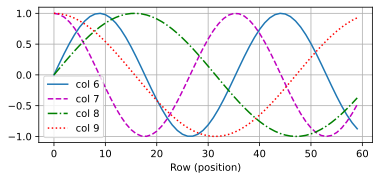

In [39]:
d2l.plot(
    torch.arange(num_steps), p[0, :, 6:10].T, 
    xlabel = 'Row (position)', figsize = (6, 2.5), 
    legend = ["col %d" % d for d in torch.arange(6, 10)])

In [40]:
# 绝对位置信息
for i in range(8):
    print(f"{i} in binary is {i:>03b}")

0 in binary is 000
1 in binary is 001
2 in binary is 010
3 in binary is 011
4 in binary is 100
5 in binary is 101
6 in binary is 110
7 in binary is 111


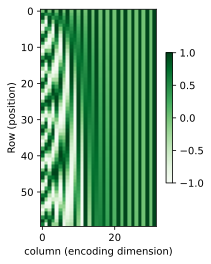

In [41]:
p = p[0, :, :].unsqueeze(0).unsqueeze(0)
d2l.show_heatmaps(
    p, xlabel = 'column (encoding dimension)', 
    ylabel = "Row (position)", figsize = (3.5, 4), 
    cmap = 'Greens')

In [6]:
# 7.Transformer
import torch
from torch import nn
from d2l import torch as d2l
import math
import pandas as pd

In [7]:
# 基于位置的前馈网络
class PositionWiseFFN(nn.Module):  #@save
    def __init__(
        self, ffn_num_inputs, ffn_num_hiddens, 
        ffn_num_outputs, **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(
            ffn_num_inputs, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(
            ffn_num_hiddens, ffn_num_outputs)
    def forward(self, x):
        return self.dense2(self.relu(self.dense1(x)))

In [8]:
ffn = PositionWiseFFN(4, 4, 8)
ffn.eval()

PositionWiseFFN(
  (dense1): Linear(in_features=4, out_features=4, bias=True)
  (relu): ReLU()
  (dense2): Linear(in_features=4, out_features=8, bias=True)
)

In [9]:
ffn(torch.ones((2, 3, 4)))[0].size()

torch.Size([3, 8])

In [10]:
# 残差连接和层归一化
ln = nn.LayerNorm(2)
bn = nn.BatchNorm1d(2)
x = torch.tensor([[1, 2], [2, 3]], dtype = torch.float32)

In [11]:
print("layer norm: ", ln(x), "\nbatch norm: ", bn(x))

layer norm:  tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward>) 
batch norm:  tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward>)


In [12]:
#@save
class AddNorm(nn.Module):
    def __init__(
        self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)
    def forward(self, x, y):
        return self.ln(self.dropout(y) + x)

In [13]:
x = torch.ones((2, 3, 4))
y = torch.ones((2, 3, 4))
add_norm = AddNorm([3, 4], 0.5)
add_norm.eval()

AddNorm(
  (dropout): Dropout(p=0.5, inplace=False)
  (ln): LayerNorm((3, 4), eps=1e-05, elementwise_affine=True)
)

In [14]:
add_norm(x, y).size()

torch.Size([2, 3, 4])

In [15]:
# 编码器
#@save
class EncoderBlock(nn.Module):
    def __init__(
        self, key_size, query_size, value_size, 
        num_hiddens, norm_shape, 
        ffn_num_input, ffn_num_hiddens, num_heads, 
        dropout, use_bias = False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = d2l.MultiHeadAttention(
            key_size, query_size, value_size, 
            num_hiddens, num_heads, dropout, use_bias)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(
            ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)
    def forward(self, x, valid_lens):
        y = self.addnorm1(
            x, self.attention(x, x, x, valid_lens))
        return self.addnorm2(y, self.ffn(y))

In [16]:
x = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = EncoderBlock(
    24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5)
encoder_blk.eval()

EncoderBlock(
  (attention): MultiHeadAttention(
    (attention): DotProductAttention(
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (W_q): Linear(in_features=24, out_features=24, bias=False)
    (W_k): Linear(in_features=24, out_features=24, bias=False)
    (W_v): Linear(in_features=24, out_features=24, bias=False)
    (W_o): Linear(in_features=24, out_features=24, bias=False)
  )
  (addnorm1): AddNorm(
    (dropout): Dropout(p=0.5, inplace=False)
    (ln): LayerNorm((100, 24), eps=1e-05, elementwise_affine=True)
  )
  (ffn): PositionWiseFFN(
    (dense1): Linear(in_features=24, out_features=48, bias=True)
    (relu): ReLU()
    (dense2): Linear(in_features=48, out_features=24, bias=True)
  )
  (addnorm2): AddNorm(
    (dropout): Dropout(p=0.5, inplace=False)
    (ln): LayerNorm((100, 24), eps=1e-05, elementwise_affine=True)
  )
)

In [17]:
encoder_blk(x, valid_lens).shape

torch.Size([2, 100, 24])

In [18]:
#@save
class TransformerEncoder(d2l.Encoder):
    def __init__(
        self, vocab_size, key_size, query_size, value_size, 
        num_hiddens, norm_shape, ffn_num_input, 
        ffn_num_hiddens, num_heads, num_layers, 
        dropout, use_bias = False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(
            num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module(
                "block" + str(i), 
                EncoderBlock(key_size, query_size, 
                             value_size, num_hiddens, 
                             norm_shape, ffn_num_input, 
                             ffn_num_hiddens, num_heads, 
                             dropout, use_bias))
    def forward(self, x, valid_lens, *args):
        x = self.pos_encoding(
            self.embedding(x) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            x = blk(x, valid_lens)
            self.attention_weights[
                i] = blk.attention.attention.attention_weights
        # print(len(self.blks))
        return x

In [19]:
encoder = TransformerEncoder(
    200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5)
encoder.eval()
x = torch.ones((2, 100), dtype = torch.long)
encoder(x, valid_lens).size()

torch.Size([2, 100, 24])

In [20]:
# 解码器
class DecoderBlock(nn.Module):
    def __init__(
        self, key_size, query_size, value_size, num_hiddens, 
        norm_shape, ffn_num_input, ffn_num_hiddens, 
        num_heads, dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i
        self.attention1 = d2l.MultiHeadAttention(
            key_size, query_size, value_size, 
            num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.attention2 = d2l.MultiHeadAttention(
            key_size, query_size, value_size, 
            num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(
            ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)
    def forward(self, x, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        if state[2][self.i] is None:
            key_values = x
        else:
            key_values = torch.cat(
                (state[2][self.i], x), axis = 1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = x.shape
            dec_valid_lens = torch.arange(
                1, num_steps + 1, 
                device = x.device).repeat(
                batch_size, 1)
        else:
            dec_valid_lens = None
        x2 = self.attention1(
            x, key_values, key_values, dec_valid_lens)
        y = self.addnorm1(x, x2)
        y2 = self.attention2(
            y, enc_outputs, enc_outputs, enc_valid_lens)
        z = self.addnorm2(y, y2)
        return self.addnorm3(z, self.ffn(z)), state

In [21]:
decoder_blk = DecoderBlock(
    24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5, 0)
decoder_blk.eval()

DecoderBlock(
  (attention1): MultiHeadAttention(
    (attention): DotProductAttention(
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (W_q): Linear(in_features=24, out_features=24, bias=False)
    (W_k): Linear(in_features=24, out_features=24, bias=False)
    (W_v): Linear(in_features=24, out_features=24, bias=False)
    (W_o): Linear(in_features=24, out_features=24, bias=False)
  )
  (addnorm1): AddNorm(
    (dropout): Dropout(p=0.5, inplace=False)
    (ln): LayerNorm((100, 24), eps=1e-05, elementwise_affine=True)
  )
  (attention2): MultiHeadAttention(
    (attention): DotProductAttention(
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (W_q): Linear(in_features=24, out_features=24, bias=False)
    (W_k): Linear(in_features=24, out_features=24, bias=False)
    (W_v): Linear(in_features=24, out_features=24, bias=False)
    (W_o): Linear(in_features=24, out_features=24, bias=False)
  )
  (addnorm2): AddNorm(
    (dropout): Dropout(p=0.5, inplace=False)
    (ln): Lay

In [22]:
x = torch.ones((2, 100, 24))
encoder_blk(x, valid_lens).size()

torch.Size([2, 100, 24])

In [23]:
state = [encoder_blk(x, valid_lens), valid_lens, [None]]
decoder_blk(x, state)[0].size()

torch.Size([2, 100, 24])

In [24]:
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(
        self, vocab_size, key_size, query_size, 
        value_size, num_hiddens, norm_shape, 
        ffn_num_input, ffn_num_hiddens, num_heads, 
        num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(
            vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block" + str(i), DecoderBlock(
                key_size, query_size, value_size, 
                num_hiddens, norm_shape, ffn_num_input, 
                ffn_num_hiddens, num_heads, 
                dropout, i))
        self.dense = nn.Linear(num_hiddens, vocab_size)
    def init_state(
        self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]
    def forward(self, x, state):
        x = self.pos_encoding(
            self.embedding(x) * math.sqrt(self.num_hiddens))
        self._attention_weights = [
            [None] * len(self.blks) for _ in range(2)]
        for i, blk in enumerate(self.blks):
            x, state = blk(x, state)
            self._attention_weights[0][
                i] = blk.attention1.attention.attention_weights
            self._attention_weights[1][
                i] = blk.attention2.attention.attention_weights
        return self.dense(x), state
    @property
    def attention_weights(self):
        return self._attention_weights

In [25]:
# 训练
num_hiddens, num_layers, dropout = 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

In [26]:
train_iter, src_vocab, tgt_vocab = load_data_nmt(
    batch_size, num_steps)

In [27]:
encoder = TransformerEncoder(
    len(src_vocab), key_size, query_size, 
    value_size, num_hiddens, norm_shape, 
    ffn_num_input, ffn_num_hiddens, num_heads, 
    num_layers, dropout)
encoder.eval()

TransformerEncoder(
  (embedding): Embedding(184, 32)
  (pos_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (blks): Sequential(
    (block0): EncoderBlock(
      (attention): MultiHeadAttention(
        (attention): DotProductAttention(
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (W_q): Linear(in_features=32, out_features=32, bias=False)
        (W_k): Linear(in_features=32, out_features=32, bias=False)
        (W_v): Linear(in_features=32, out_features=32, bias=False)
        (W_o): Linear(in_features=32, out_features=32, bias=False)
      )
      (addnorm1): AddNorm(
        (dropout): Dropout(p=0.1, inplace=False)
        (ln): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      )
      (ffn): PositionWiseFFN(
        (dense1): Linear(in_features=32, out_features=64, bias=True)
        (relu): ReLU()
        (dense2): Linear(in_features=64, out_features=32, bias=True)
      )
      (addnorm2): AddNorm(
        (dropo

In [28]:
decoder = TransformerDecoder(
    len(tgt_vocab), key_size, query_size, 
    value_size, num_hiddens, norm_shape, 
    ffn_num_input, ffn_num_hiddens, num_heads, 
    num_layers, dropout)
decoder.eval()

TransformerDecoder(
  (embedding): Embedding(201, 32)
  (pos_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (blks): Sequential(
    (block0): DecoderBlock(
      (attention1): MultiHeadAttention(
        (attention): DotProductAttention(
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (W_q): Linear(in_features=32, out_features=32, bias=False)
        (W_k): Linear(in_features=32, out_features=32, bias=False)
        (W_v): Linear(in_features=32, out_features=32, bias=False)
        (W_o): Linear(in_features=32, out_features=32, bias=False)
      )
      (addnorm1): AddNorm(
        (dropout): Dropout(p=0.1, inplace=False)
        (ln): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      )
      (attention2): MultiHeadAttention(
        (attention): DotProductAttention(
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (W_q): Linear(in_features=32, out_features=32, bias=False)
        (W_k): Linear(in_feat

In [29]:
net = d2l.EncoderDecoder(encoder, decoder)

loss 0.020, 5317.7 tokens/sec on cuda:0


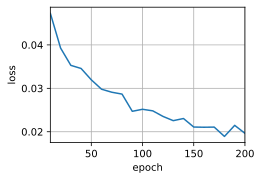

In [30]:
d2l.train_seq2seq(
    net, train_iter, lr, num_epochs, tgt_vocab, device)

In [31]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ', 
          f'bleu {d2l.bleu(translation, fra, k = 1 ):.3f}')

go . => <unk> !,  bleu 0.707
i lost . => <unk> <unk> .,  bleu 0.577
he's calm . => <unk> <unk> <unk> .,  bleu 0.500
i'm home . => <unk> <unk> <unk> .,  bleu 0.389


In [32]:
enc_attention_weights = torch.cat(
    net.encoder.attention_weights, 0).reshape(
    (num_layers, num_heads, -1, num_steps))
enc_attention_weights.shape

torch.Size([2, 4, 10, 10])

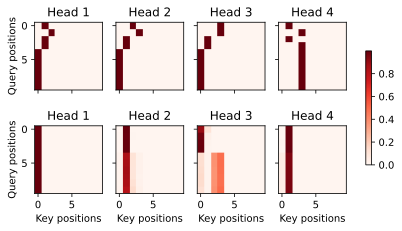

In [38]:
d2l.show_heatmaps(
    enc_attention_weights.cpu(), 
    xlabel='Key positions',
    ylabel='Query positions', 
    titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))

In [39]:
dec_attention_weights_2d = [
    head[0].tolist() 
    for step in dec_attention_weight_seq 
    for attn in step 
    for blk in attn 
    for head in blk]
dec_attention_weights_filled = torch.tensor(
    pd.DataFrame(
        dec_attention_weights_2d).fillna(0.0).values)
dec_attention_weights = dec_attention_weights_filled.reshape(
    (-1, 2, num_layers, num_heads, num_steps))
dec_self_attention_weights, dec_inter_attention_weights=\
    dec_attention_weights.permute(1, 2, 3, 0, 4)
dec_self_attention_weights.shape, dec_inter_attention_weights.shape

(torch.Size([2, 4, 5, 10]), torch.Size([2, 4, 5, 10]))

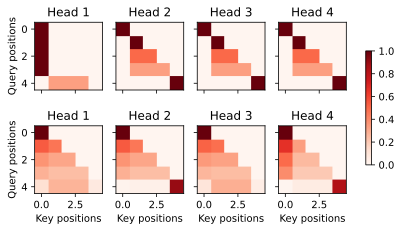

In [40]:
d2l.show_heatmaps(
    dec_self_attention_weights[
        :, :, :, :len(translation.split()) + 1],
xlabel='Key positions', ylabel='Query positions',
titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))

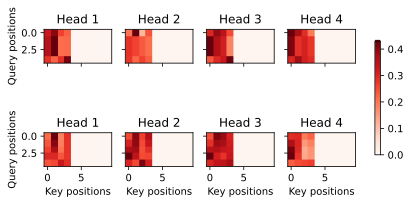

In [41]:
d2l.show_heatmaps(
    dec_inter_attention_weights, xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))